# Aprendiendo Fashion-MNIST con PyTorch

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

/bin/bash: línea 1: /home/usuario/Documentos/RedesNeuronales/RN-FinalProyect/.venv/bin/pip3: no se puede ejecutar: no se ha encontrado el fichero requerido


In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme (i.e. normalize los valores de los pixeles) los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**3)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**4)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [6]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([
                                transforms.ToTensor()
                                #,transforms.Normalize((0.5,), (0.5,))
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
train_set = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

100.0%
100.0%
100.0%
100.0%


In [7]:
# 2.2)
len(train_set),len(valid_set)

(60000, 10000)

In [8]:
i = np.random.randint(len(train_set))
print(f"i={i}")
image,label = train_set[i]
label
image.shape

i=2359


torch.Size([1, 28, 28])

In [9]:
image.numpy().squeeze().shape

(28, 28)

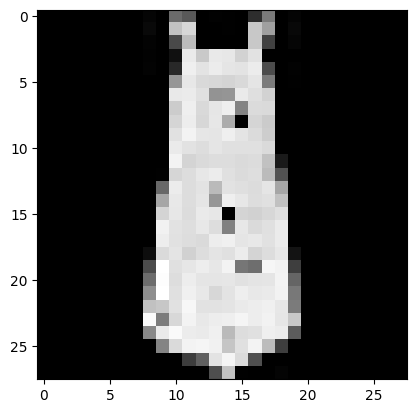

In [10]:
plt.imshow(image.numpy().squeeze(),cmap='Greys_r')

In [11]:
# 2.3)
label_names = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

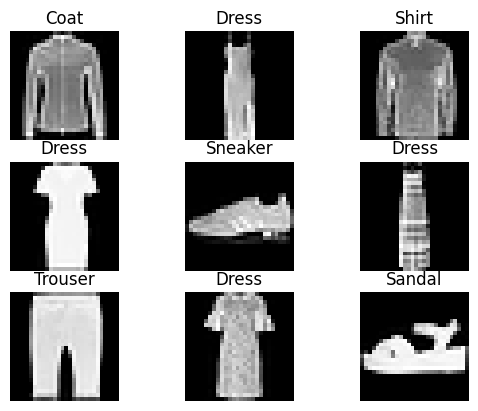

In [12]:
# 2.4)
figure = plt.figure()
cols, rows = 3,3
for i in range(1, cols*rows+1):
  j = torch.randint(len(train_set), size=(1,)).item()
  image, label = train_set[j]
  figure.add_subplot(rows, cols, i)
  plt.title(label_names[label])
  plt.axis("off")
  plt.imshow(image.numpy().squeeze(), cmap="Greys_r")
plt.show()

## Ejercicio 3)

Creando un `DataLoader` para alimentar el modelo con batchs (lotes) de entrenamiento.

**1)** Cree los `DataLoader`s para cada conjunto. Defínalos con un `batch_size` de 100 y con el flag `shuffle` seteado a `True`.

**2)** Use uno de los `DataLoader`s creados anteriormente para explorar algunos elementos del conjunto.

Notar que, el iterador devuelve el batch en un par `(image,label)`.

El objeto `images` es un tensor de dimensiones `(100,1,28,28)`.
El 100 es el tamaño del batch.
El 1 porque hay un solo canal (en este caso, un canal de escala de grises, pero podría haber varios, p. ej. uno por cada color de {Red, Green Blue} en caso que fuesen imagenes a color).
Luego, 28 y 28 porque cada imagen del dataset es de 28 x 28 píxeles.

El objeto `labels` es un tensor de dimensiones `(100,)`.
La $i$-ésima entrada `labels[i]` de `labels` es un número en $\{0,1,...,9\}$ indicando la categoría a la que pertenece la $i$-ésima imagen en el batch, guardada en `images[i]`.

In [13]:
# 3.1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 100, shuffle = True)

In [14]:
# Cargar únicamente los pesos del Autoencoder preentrenado
import torch
from torch import nn
# Debes tener la misma definición de Autoencoder que se usó al entrenar
from autoencoder import Autoencoder  

checkpoint_path = "/home/usuario/Documentos/RedesNeuronales/RN-FinalProyect/Autoencoder/3_final/resultados/loss_results.pt"
checkpoint = torch.load(checkpoint_path, map_location="cpu")

dropout_autoencoder = 0.2
autoencoder = Autoencoder(dropout=dropout_autoencoder)
autoencoder.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

## Ejercicio 4)

Defina una red neuronal de 4 capas, una de entrada, dos ocultas de $n_1=128$ y $n_2=64$ neuronas, respectivamente, y una de salida de 10 neuronas.

En las capas intermedias utilice neuronas tipo ReLU y agregueles un *dropout* de p=0.2.
En la capa de salida no utilice funciones de activación ni dropout.

Las capas sucesivas tienen que estar totalmente conectadas entre si.

In [15]:
class Clasificadora1(nn.Module):
    def __init__(self, p, n1, n2, encoder=None):
        super().__init__()
        self._dropout = p

        self.encoder = encoder
        self.classifier = nn.Sequential(
            # Capa 0
            nn.Flatten(),
            
            # Capa 1
            nn.Linear(in_features = 64*7*7, out_features = n1),
            nn.ReLU(),
            nn.Dropout(p),
            
            # Capa 2
            nn.Linear(in_features = n1, out_features = n2),
            nn.ReLU(),
            nn.Dropout(p),

            # Capa 3
            nn.Linear(in_features = n2, out_features = 10)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x


class Clasificadora2(nn.Module):
    def __init__(self, p, n1, n2, n3, encoder=None):
        super().__init__()
        self._dropout = p

        self.encoder = encoder
        self.classifier = nn.Sequential(
            # Capa 0
            nn.Flatten(),
            
            # Capa 1
            nn.Linear(in_features = 64*7*7, out_features = n1),
            nn.ReLU(),
            nn.Dropout(p),
            
            # Capa 2
            nn.Linear(in_features = n1, out_features = n2),
            nn.ReLU(),
            nn.Dropout(p),
            
            # Capa 2
            nn.Linear(in_features = n2, out_features = n3),
            nn.ReLU(),
            nn.Dropout(p),

            # Capa 3
            nn.Linear(in_features = n3, out_features = 10)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

## Ejercicio 5)

Entrenamos el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` a partir del `train_set` (conjunto de entranmiento) y del `valid_set` (conjunto de validación) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando la **Cross Entropy Loss**.

**IMPORTANTE:** Notar que la **Cross Entropy Loss** aplica automáticamente una `log_softmax`.

**5)** Cree un optimizador que utilice el método de **Stochastic Gradient Descent** con un learning rate igual a $10^{-3}$.

**6)** Cree una instancia del modelo.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader`, respectivamente, usando un numero arbitrario de épocas.
Este loop debe guardar en cuatro listas los valores de los promedios del **Cross Entropy Loss** y las fracciones de clasificaciones correctas o **precisión** (accuracy) sobre el conjunto de **entrenamiento** y el de **validación**, respectivamente.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso anterior para graficar en función de las épocas la **Cross Entropy Loss** de **entrenamiento** y de **validación**.
Realize un gráfico análogo pero con la **precisión**.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Repita los experimentos variando hiperparámetros. Por ejemplo:

- El learning-rate.
- El optimizador (ej. puede usar ADAM).
- El valor de dropout.
- El número de neuronas en las capas intermedias.
- El número de épocas de entrenamiento.
- El tamaño de los lotes.

Discuta los resultados.

In [16]:
# 5.1)
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    num_samples = len(dataloader.dataset)
    nun_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        batch_size = len(X)
        sum_samples += batch_size
        pred = model(X)
        loss = loss_fn(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()*batch_size
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % (nun_batches/10) == 0:
            avrg_loss = sum_loss/sum_samples
            precision = sum_correct/sum_samples
            print(f"@train_loop batch={batch:>5d} avrg_loss={avrg_loss:>7f} processed samples={100*sum_samples/num_samples:>5.1f}%")
    assert num_samples == sum_samples
    avrg_loss = sum_loss/sum_samples
    precision = sum_correct/sum_samples
    return avrg_loss, precision

In [17]:
# 5.2)
# Definimos la función de validación
def eval_loop(dataloader, model, loss_fn):
    model.eval()
    num_samples = len(dataloader.dataset)
    nun_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0

    with torch.no_grad():
        for X,y in dataloader:
          X = X.to(device)
          y = y.to(device)
          batch_size = len(X)
          sum_samples += batch_size
          pred = model(X)
          loss = loss_fn(pred,y)
          sum_loss += loss.item()*batch_size
          sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    assert num_samples == sum_samples
    avrg_loss = sum_loss/sum_samples
    precision = sum_correct/sum_samples
    print(f"@eval_loop avg_loss={avrg_loss:>8f} precision={100*precision:>0.1f}%")
    return avrg_loss, precision

In [18]:
# 5.3)
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print(f'num_train_batches={num_train_batches}')
print(f'num_valid_batches={num_valid_batches}')

num_train_batches=600
num_valid_batches=100


In [19]:
# 5.4)
loss_fn = nn.CrossEntropyLoss()

In [20]:
# 5.5)
# Ejemplo: pasar encoder a tu modelo Clasificadora con dropout fijo en la clasificadora
# p_dropout_clf = 0.2
# clasificador = Clasificadora(p=p_dropout_clf, n1=128, n2=64, encoder=autoencoder.encoder)

In [21]:
# 5.6)
#learning_rate = 1e-3
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(clasificador.classifier.parameters(), lr=learning_rate, eps=1e-08, weight_decay= 0, amsgrad= False)

In [22]:
# 5.7)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#clasificador = clasificador.to(device)

In [24]:
# -------------------------
# Configuración común
# -------------------------
p_dropout_clf = 0.2
learning_rate = 1e-3
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.CrossEntropyLoss()  # Ejemplo, usar el que tengas
results_base_path = "results"

# Crear carpeta base si no existe
os.makedirs(results_base_path, exist_ok=True)

# -------------------------
# BLOQUE 2: Clasificadora 3 capas
# -------------------------
experimentos_3capas = {
    "Exp1": {"n1": 128, "n2": 64,  "n3": 32},
    "Exp2": {"n1": 256, "n2": 128, "n3": 64},
    "Exp3": {"n1": 512, "n2": 256, "n3": 128}
}

results_3capas = {}
path_3capas = os.path.join(results_base_path, "3capas")
os.makedirs(path_3capas, exist_ok=True)

for nombre_exp, params in experimentos_3capas.items():
    print(f"\n============================")
    print(f"      EJECUTANDO 3CAPAS {nombre_exp}")
    print(f"============================")

    clf = Clasificadora2(
        p=p_dropout_clf,
        n1=params["n1"],
        n2=params["n2"],
        n3=params["n3"],
        encoder=autoencoder.encoder
    ).to(device)

    optimizer = torch.optim.Adam(clf.classifier.parameters(), lr=learning_rate)

    # Inicializar listas de métricas
    list_avg_train_loss_incorrecta = []
    list_avg_train_loss = []
    list_avg_valid_loss = []
    list_train_precision_incorrecta = []
    list_train_precision = []
    list_valid_precision = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        # TRAIN LOOP con métricas incorrectas
        train_avg_loss_incorrecta, train_precision_incorrecta = train_loop(train_loader, clf, loss_fn, optimizer)
        # TRAIN LOOP normal (solo monitoreo)
        train_avg_loss, train_precision = eval_loop(train_loader, clf, loss_fn)
        # VALID LOOP
        valid_avg_loss, valid_precision = eval_loop(valid_loader, clf, loss_fn)

        # Guardar métricas
        list_avg_train_loss_incorrecta.append(train_avg_loss_incorrecta)
        list_avg_train_loss.append(train_avg_loss)
        list_avg_valid_loss.append(valid_avg_loss)
        list_train_precision_incorrecta.append(train_precision_incorrecta)
        list_train_precision.append(train_precision)
        list_valid_precision.append(valid_precision)

    # --------------------
    # Guardar resultados por experimento (métricas + config)
    # --------------------
    results_3capas[nombre_exp] = {
        "config": {
            "tipo_modelo": "Clasificadora2",
            "p_dropout_clf": p_dropout_clf,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "n1": params["n1"],
            "n2": params["n2"],
            "n3": params["n3"],
        },
        "train_loss_incorrecta": list_avg_train_loss_incorrecta,
        "train_loss": list_avg_train_loss,
        "valid_loss": list_avg_valid_loss,
        "train_precision_incorrecta": list_train_precision_incorrecta,
        "train_precision": list_train_precision,
        "valid_precision": list_valid_precision,
    }

    # Guardar métricas en archivo .pkl
    with open(os.path.join(path_3capas, f"{nombre_exp}_results.pkl"), "wb") as f:
        pickle.dump(results_3capas[nombre_exp], f)

    # Guardar pesos del modelo y estado del optimizador en .pt
    torch.save(
        {
            "config": results_3capas[nombre_exp]["config"],
            "model_state_dict": clf.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        os.path.join(path_3capas, f"{nombre_exp}_model.pt"),
    )

    # Guardar resumen corto en JSON con últimos valores
    resumen = {
        "config": results_3capas[nombre_exp]["config"],
        "final_train_loss": list_avg_train_loss[-1],
        "final_valid_loss": list_avg_valid_loss[-1],
        "final_train_precision": list_train_precision[-1],
        "final_valid_precision": list_valid_precision[-1],
    }
    with open(os.path.join(path_3capas, f"{nombre_exp}_summary.json"), "w") as fjson:
        json.dump(resumen, fjson, indent=4)

print("✅ BLOQUE 3 CAPAS FINALIZADO")


      EJECUTANDO 3CAPAS Exp1

Epoch 1/100
@train_loop batch=    0 avrg_loss=2.303775 processed samples=  0.2%
@train_loop batch=   60 avrg_loss=1.538050 processed samples= 10.2%
@train_loop batch=  120 avrg_loss=1.239481 processed samples= 20.2%
@train_loop batch=  180 avrg_loss=1.082913 processed samples= 30.2%
@train_loop batch=  240 avrg_loss=0.982769 processed samples= 40.2%
@train_loop batch=  300 avrg_loss=0.906200 processed samples= 50.2%
@train_loop batch=  360 avrg_loss=0.854491 processed samples= 60.2%
@train_loop batch=  420 avrg_loss=0.810592 processed samples= 70.2%
@train_loop batch=  480 avrg_loss=0.778312 processed samples= 80.2%
@train_loop batch=  540 avrg_loss=0.750311 processed samples= 90.2%
@eval_loop avg_loss=0.438492 precision=83.7%
@eval_loop avg_loss=0.461792 precision=82.7%

Epoch 2/100
@train_loop batch=    0 avrg_loss=0.452868 processed samples=  0.2%
@train_loop batch=   60 avrg_loss=0.498660 processed samples= 10.2%
@train_loop batch=  120 avrg_loss=0.49

In [26]:
# -------------------------
# RESULTADOS FINALES BLOQUE 3 CAPAS
# -------------------------
print("\n============================")
print("   RESULTADOS FINALES BLOQUE 3 CAPAS")
print("============================")

final_results_3capas = {}

for exp in results_3capas:
    train_loss_final = results_3capas[exp]["train_loss"][-1]
    valid_loss_final = results_3capas[exp]["valid_loss"][-1]
    train_prec_final = results_3capas[exp]["train_precision"][-1]
    valid_prec_final = results_3capas[exp]["valid_precision"][-1]

    final_results_3capas[exp] = valid_prec_final

    print(f"\n--- {exp} ---")
    print(f"Train Loss final:       {train_loss_final:.4f}")
    print(f"Valid Loss final:       {valid_loss_final:.4f}")
    print(f"Train Precision final:  {train_prec_final:.4f}")
    print(f"Valid Precision final:  {valid_prec_final:.4f}")

# Elegir mejor experimento 3 capas
best_exp_3capas = max(final_results_3capas, key=final_results_3capas.get)
best_precision_3capas = final_results_3capas[best_exp_3capas]

print("\n============================")
print("   MEJOR EXPERIMENTO BLOQUE 3 CAPAS")
print("============================")
print(f"Ganador: {best_exp_3capas}")
print(f"Mejor Valid Precision: {best_precision_3capas:.4f}")



   RESULTADOS FINALES BLOQUE 3 CAPAS

--- Exp1 ---
Train Loss final:       0.1698
Valid Loss final:       0.2669
Train Precision final:  0.9365
Valid Precision final:  0.9092

--- Exp2 ---
Train Loss final:       0.1600
Valid Loss final:       0.2850
Train Precision final:  0.9393
Valid Precision final:  0.9053

--- Exp3 ---
Train Loss final:       0.1598
Valid Loss final:       0.2662
Train Precision final:  0.9405
Valid Precision final:  0.9109

   MEJOR EXPERIMENTO BLOQUE 3 CAPAS
Ganador: Exp3
Mejor Valid Precision: 0.9109


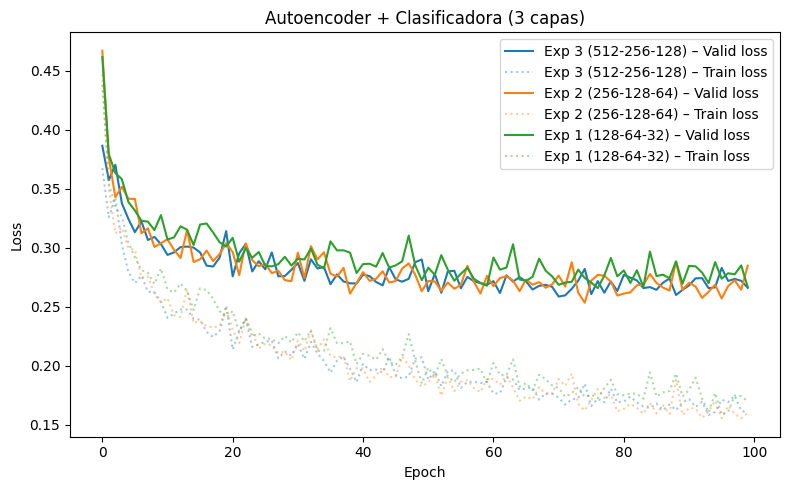

In [46]:
# ----------------------------
#       GRÁFICO BLOQUE 3 CAPAS
# ----------------------------

exp_labels_3capas = {
    "Exp1": "Exp 1 (128-64-32)",
    "Exp2": "Exp 2 (256-128-64)",
    "Exp3": "Exp 3 (512-256-128)"
}

# Usar mismos colores que en el bloque de 2 capas:
# Exp1 → C0 (azul), Exp2 → C1 (naranja), Exp3 → C2 (verde)
exp_colors_3capas = {
    "Exp1": "C2",
    "Exp2": "C1",
    "Exp3": "C0",
}

plt.figure(figsize=(8,5))

for exp in results_3capas:
    epochs = range(len(results_3capas[exp]["valid_loss"]))  # eje x correcto
    color = exp_colors_3capas.get(exp, "C0")

    plt.plot(
        epochs,
        results_3capas[exp]["valid_loss"],
        label=f'{exp_labels_3capas[exp]} – Valid loss',
        linestyle="-",
        color=color,
    )

    plt.plot(
        epochs,
        results_3capas[exp]["train_loss"],
        label=f'{exp_labels_3capas[exp]} – Train loss',
        linestyle=":",
        color=color,
        alpha=0.40,
    )

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder + Clasificadora (3 capas)")
plt.legend()
plt.tight_layout()
plt.savefig("results/3capas/experimentos_loss_3capas.png")
plt.show()

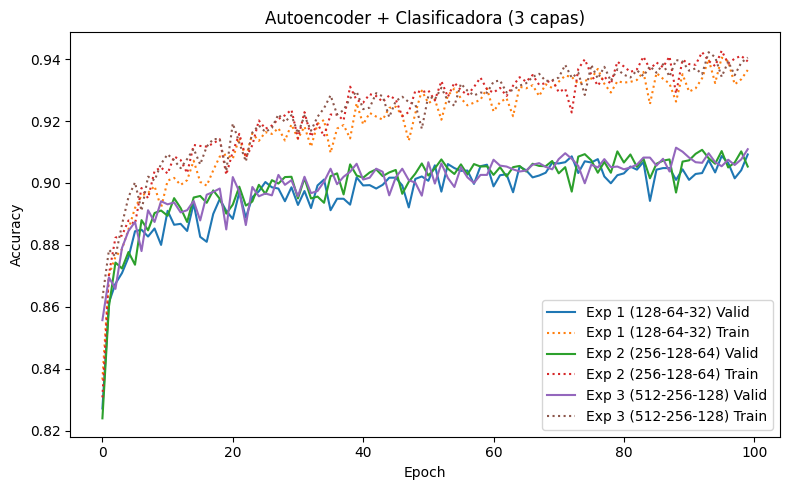

In [29]:
# ----------------------------
#       GRÁFICO ACCURACY BLOQUE 3 CAPAS
# ----------------------------
plt.figure(figsize=(8,5))

for exp in results_3capas:
    epochs = range(len(results_3capas[exp]["valid_precision"]))  # eje x correcto

    plt.plot(epochs, results_3capas[exp]["valid_precision"],
             label=f'{exp_labels_3capas[exp]} Valid',
             linestyle="-")

    plt.plot(epochs, results_3capas[exp]["train_precision"],
             label=f'{exp_labels_3capas[exp]} Train',
             linestyle=":")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Autoencoder + Clasificadora (3 capas)")
plt.legend()
plt.tight_layout()
plt.savefig("results/3capas/experimentos_accuracy_3capas.png")
plt.show()


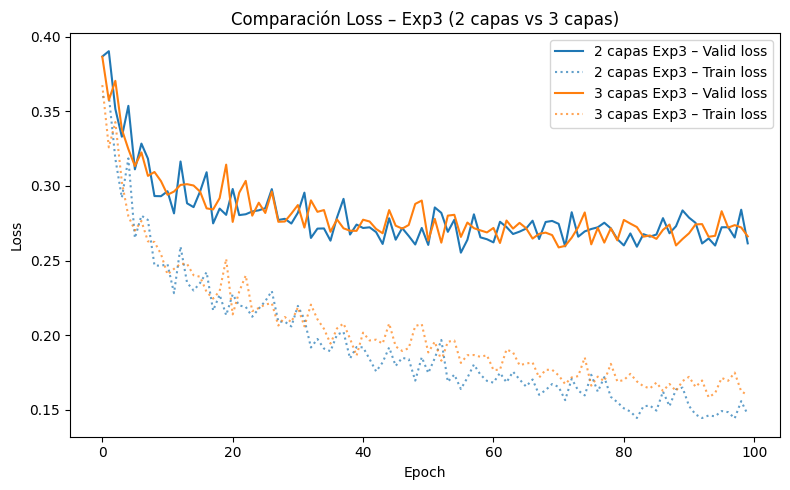

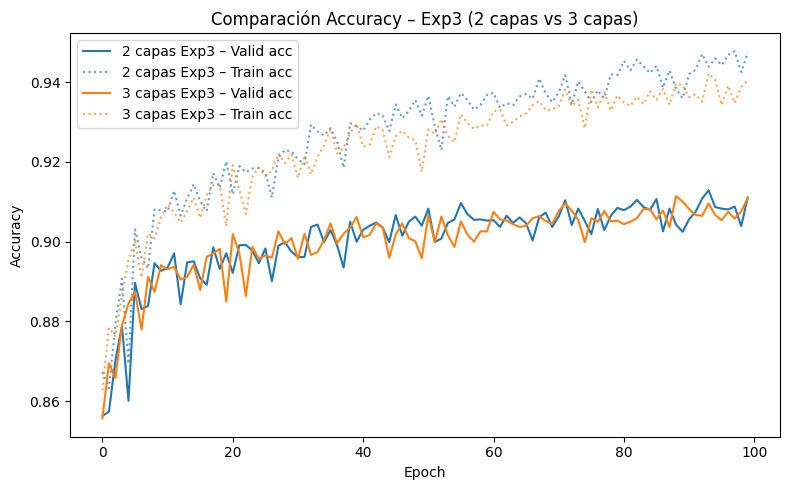

In [35]:
# ----------------------------
# COMPARACIÓN EXP3: 2 CAPAS vs 3 CAPAS
# Mejores valores de loss y accuracy por época
# ----------------------------
import os
import pickle
import matplotlib.pyplot as plt

# Rutas de resultados
path_2capas = os.path.join("results", "2capas")
path_3capas = os.path.join("results", "3capas")

# Cargar resultados Exp3 2 capas
results_2capas = {}
if os.path.exists(path_2capas):
    for fname in os.listdir(path_2capas):
        if fname.endswith("_results.pkl"):
            exp_name = fname.replace("_results.pkl", "")
            with open(os.path.join(path_2capas, fname), "rb") as f:
                results_2capas[exp_name] = pickle.load(f)

# Cargar resultados Exp3 3 capas (ya tenemos results_3capas en memoria,
# pero si se ejecuta esta celda sola, lo recargamos por seguridad)
if 'results_3capas' not in globals():
    results_3capas = {}
    if os.path.exists(path_3capas):
        for fname in os.listdir(path_3capas):
            if fname.endswith("_results.pkl"):
                exp_name = fname.replace("_results.pkl", "")
                with open(os.path.join(path_3capas, fname), "rb") as f:
                    results_3capas[exp_name] = pickle.load(f)

# Verificamos que exista Exp3 en ambos bloques
if "Exp3" not in results_2capas or "Exp3" not in results_3capas:
    print("⚠️ No se encontró Exp3 en 2capas o 3capas. Verifique los archivos de resultados.")
else:
    datos_2c = results_2capas["Exp3"]
    datos_3c = results_3capas["Exp3"]

    # Series
    loss_train_2c = datos_2c["train_loss"]
    loss_valid_2c = datos_2c["valid_loss"]
    acc_train_2c  = datos_2c["train_precision"]
    acc_valid_2c  = datos_2c["valid_precision"]

    loss_train_3c = datos_3c["train_loss"]
    loss_valid_3c = datos_3c["valid_loss"]
    acc_train_3c  = datos_3c["train_precision"]
    acc_valid_3c  = datos_3c["valid_precision"]

    epochs_2c = range(len(loss_valid_2c))
    epochs_3c = range(len(loss_valid_3c))

    # ----------------------------
    # Gráfico de Loss (Train y Valid) Exp3 2c vs 3c
    # ----------------------------
    plt.figure(figsize=(8,5))

    # 2 capas
    plt.plot(epochs_2c, loss_valid_2c, label="2 capas Exp3 – Valid loss", color="C0", linestyle="-")
    plt.plot(epochs_2c, loss_train_2c, label="2 capas Exp3 – Train loss", color="C0", linestyle=":", alpha=0.7)

    # 3 capas
    plt.plot(epochs_3c, loss_valid_3c, label="3 capas Exp3 – Valid loss", color="C1", linestyle="-")
    plt.plot(epochs_3c, loss_train_3c, label="3 capas Exp3 – Train loss", color="C1", linestyle=":", alpha=0.7)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Comparación Loss – Exp3 (2 capas vs 3 capas)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join("results", "comparacion_loss_best2_vs_best3.png"))
    plt.show()

    # ----------------------------
    # Gráfico de Accuracy (Train y Valid) Exp3 2c vs 3c
    # ----------------------------
    plt.figure(figsize=(8,5))

    # 2 capas
    plt.plot(epochs_2c, acc_valid_2c, label="2 capas Exp3 – Valid acc", color="C0", linestyle="-")
    plt.plot(epochs_2c, acc_train_2c, label="2 capas Exp3 – Train acc", color="C0", linestyle=":", alpha=0.7)

    # 3 capas
    plt.plot(epochs_3c, acc_valid_3c, label="3 capas Exp3 – Valid acc", color="C1", linestyle="-")
    plt.plot(epochs_3c, acc_train_3c, label="3 capas Exp3 – Train acc", color="C1", linestyle=":", alpha=0.7)

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Comparación Accuracy – Exp3 (2 capas vs 3 capas)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join("results", "comparacion_precision_best2_vs_best3.png"))
    plt.show()